In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open(r'/content/drive/MyDrive/makemore/names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:(i+1) for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {(i+1):s for i,s in enumerate(chars)}
itos[0] = '.'
vocab_size = len(itos)

In [4]:
import random
random.seed(42)
random.shuffle(words)

In [5]:
block_size = 3
def build_dataset(words):
  X,Y = [],[]
  for w in words:
    context = [0] * block_size
    for ch in w+'.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X,Y

n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)
Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])
Xtr.shape,Xdev.shape,Xte.shape

(torch.Size([182625, 3]), torch.Size([22655, 3]), torch.Size([22866, 3]))

In [6]:
for x,y in zip(Xtr[:10],Ytr[:10]):
  print(''.join([itos[ix.item()] for ix in x]),'------>',itos[y.item()])

... ------> y
..y ------> u
.yu ------> h
yuh ------> e
uhe ------> n
hen ------> g
eng ------> .
... ------> d
..d ------> i
.di ------> o


In [7]:
class Linear:
  def __init__(self,fan_in,fan_out,bias=True):
    self.weight = torch.randn((fan_in,fan_out)) / (fan_in)**0.5
    self.bias = torch.zeros((fan_out)) if bias else None
  def __call__(self,x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
  def __init__(self,dim,eps=1e-5,momentum=0.1):
    self.eps = eps
    self.training = True
    self.momentum = momentum
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers
    self.mean_running = torch.zeros(dim)
    self.var_running = torch.ones(dim)
  def __call__(self,x):
    if self.training:
      xmean = x.mean(dim=0,keepdim=True)
      xvar = x.var(dim=0,keepdim=True)
      with torch.no_grad():
        self.mean_running = (1-self.momentum)*self.mean_running + self.momentum*xmean
        self.var_running = (1-self.momentum)*self.var_running + self.momentum*xvar
    else:
      xmean = self.mean_running
      xvar = self.var_running

    self.out = self.gamma * (x-xmean)/(torch.sqrt(xvar)+self.eps) + self.beta
    return self.out
  def parameters(self):
    return [self.gamma,self.beta]

class Tanh:
  def __call__(self,x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

torch.manual_seed(42);

In [8]:
n_embd = 10
n_hidden = 200

C = torch.randn((vocab_size,n_embd))
layers = [
    Linear(block_size*n_embd,n_hidden,bias=False),BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden,vocab_size),
]

# parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

12097


In [9]:
# optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch
  ix = torch.randint(0,len(Xtr),(batch_size,))
  Xb,Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  x = emb.view(emb.shape[0],-1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x,Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i<150000 else 0.001
  for p in parameters:
    p.data -= lr * p.grad

  # track stats
  lossi.append(loss.log10().item())
  if i%10000==0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

      0/ 200000: 3.2966
  10000/ 200000: 2.2322
  20000/ 200000: 2.4111
  30000/ 200000: 2.1004
  40000/ 200000: 2.3157
  50000/ 200000: 2.2104
  60000/ 200000: 1.9653
  70000/ 200000: 1.9767
  80000/ 200000: 2.6738
  90000/ 200000: 2.0837
 100000/ 200000: 2.2730
 110000/ 200000: 1.7491
 120000/ 200000: 2.2891
 130000/ 200000: 2.3443
 140000/ 200000: 2.1731
 150000/ 200000: 1.8246
 160000/ 200000: 1.7546
 170000/ 200000: 2.2734
 180000/ 200000: 2.0856
 190000/ 200000: 2.1299


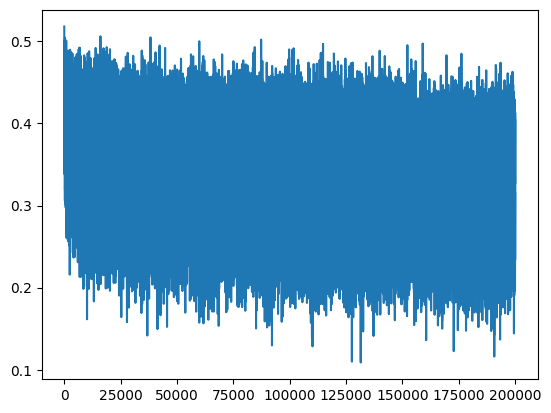

In [10]:
plt.plot(lossi)

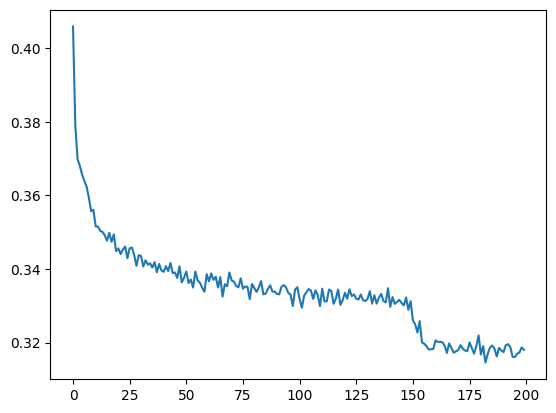

In [11]:
# let's make the plot more readable
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))
# the drop is when learning rate decay happens

In [12]:
# evaluation mode
for layer in layers:
  layer.training = False

@torch.no_grad()
def split_loss(split):
  x,y = {
      'train':[Xtr,Ytr],
      'val':[Xdev,Ydev],
      'test':[Xte,Yte]
  }[split]
  emb = C[x]
  x = emb.view(emb.shape[0],-1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x,y)
  print(split,loss.item())

split_loss('train')
split_loss('val')

train 2.060987949371338
val 2.1078128814697266


In [13]:
# sample from the model
for _ in range(10):
  out = []
  context = [0]*block_size
  while True:
    emb = C[torch.tensor([context])]
    x = emb.view(emb.shape[0],-1)
    for layer in layers:
      x = layer(x)
    logits = x
    probs = F.softmax(logits,dim=1)
    ix = torch.multinomial(probs,num_samples=1,replacement=True).item()
    context = context[1:]+[ix]
    out.append(ix)
    if ix==0:
      break
  print(''.join([itos[i] for i in out]))

damiara.
alyzah.
fard.
azarressa.
mily.
lorie.
rossot.
emon.
cani.
cian.


In [14]:
# before we dive into wavenet, let's make the code more pytorch-like
# first let's add embedding layer and flatten layer then get rid of the manual embedding
class Embedding:
  def __init__(self,num_embeddings,embedding_dim):
    self.weight = torch.randn((num_embeddings,embedding_dim))
  def __call__(self,IX):
    self.out = self.weight[IX]
    return self.out
  def parameters(self):
    return [self.weight]

class Flatten:
  def __call__(self,x):
    self.out = x.view(x.shape[0],-1)
    return self.out
  def parameters(self):
    return []

# then let's not use a list Layers, and use a Sequential container instead
class Sequential:
  def __init__(self,layers):
    self.layers = layers
  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [15]:
# now we can initialize the layers as follows
model = Sequential([
    Embedding(vocab_size,n_embd),
    Flatten(),
    Linear(block_size*n_embd,n_hidden,bias=False),BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden,vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1
parameters = model.parameters()
print(sum([p.nelement() for p in parameters]))
for p in parameters:
  p.requires_grad = True

12097


In [16]:
# with these, the training and evalutating phase can be simplified
for i in range(max_steps):
  # minibatch
  ix = torch.randint(0,len(Xtr),(batch_size,))
  Xb,Yb = Xtr[ix],Ytr[ix]

  # forward pass
  # since now the embedding layer and the flatten layer are all packed into model
  logits = model(Xb)
  loss = F.cross_entropy(logits,Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i<100000 else 0.001
  for p in parameters:
    p.data -= lr*p.grad

  # track stats
  lossi.append(loss.log10().item())
  if i%10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

  # break

      0/ 200000: 3.3034
  10000/ 200000: 2.2252
  20000/ 200000: 1.9629
  30000/ 200000: 2.3530
  40000/ 200000: 1.8835
  50000/ 200000: 2.3054
  60000/ 200000: 2.0930
  70000/ 200000: 2.3444
  80000/ 200000: 1.8753
  90000/ 200000: 2.0006
 100000/ 200000: 2.1351
 110000/ 200000: 2.3518
 120000/ 200000: 2.1857
 130000/ 200000: 2.3634
 140000/ 200000: 1.8848
 150000/ 200000: 2.0687
 160000/ 200000: 2.0986
 170000/ 200000: 2.1310
 180000/ 200000: 1.9163
 190000/ 200000: 1.6485


In [17]:
# simplify the evaluation phase
for layer in model.layers:
  layer.training = False

def split_loss(split):
  x,y = {
      'train':[Xtr,Ytr],
      'val':[Xdev,Ydev],
      'test':[Xte,Yte]
  }[split]
  loss = F.cross_entropy(model(x),y)
  print(loss.item())

split_loss('train')
split_loss('val')

2.0677003860473633
2.106633186340332


In [18]:
# simplify the sampling phase
for _ in range(10):
  out = []
  context = [0]*block_size
  while True:
    logits = model(torch.tensor([context]))
    probs = F.softmax(logits,dim=1)
    ix = torch.multinomial(probs,num_samples=1,replacement=True).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix==0:
      break
  print(''.join(itos[i] for i in out))

ira.
angel.
makessanayik.
yophid.
zon.
mege.
adatongeld.
sanimira.
kamiyannasfa.
imanel.


# Wavenet
Let's dive into this new network, yay!

In [19]:
# let's re-build the dataset, with block_size = 8
block_size = 8

Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

In [20]:
# now the dataset looks like the following
for x,y in zip(Xtr[:10],Ytr[:10]):
  print(''.join(itos[i.item()] for i in x),'--->',itos[y.item()])

........ ---> y
.......y ---> u
......yu ---> h
.....yuh ---> e
....yuhe ---> n
...yuhen ---> g
..yuheng ---> .
........ ---> d
.......d ---> i
......di ---> o


with this dataset, rerun the previous linear network, as our baseline

performance log:
  * original (context 3, 200 hidden neurons, 12K params): train 2.0679, val 2.1045

  * context 8, 200 hidden neurons, 22K params: train 1.9345, val 2.0282

In [21]:
# First, let's look at all the shapes of outputs of each layer
model = Sequential([
    Embedding(vocab_size,n_embd),
    Flatten(),
    Linear(block_size*n_embd,n_hidden,bias=False),BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden,vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1
parameters = model.parameters()
print(sum([p.nelement() for p in parameters]))
for p in parameters:
  p.requires_grad = True

ix = torch.randint(0,len(Xtr),(4,)) # let's look at a batch of just 4 examples
Xb,Yb = Xtr[ix],Ytr[ix]
logits = model(Xb)
Xb.shape

22097


torch.Size([4, 8])

In [22]:
model.layers[0].__class__.__name__,model.layers[0].out.shape
# the shape of the embedding layer output is [4,8,10], as [batch_size,block_size,n_embd]

('Embedding', torch.Size([4, 8, 10]))

In [23]:
model.layers[1].__class__.__name__,model.layers[1].out.shape
# the shape of the flatten layer output is [4,80], as [batch_size,block_size*n_embd]

('Flatten', torch.Size([4, 80]))

In [24]:
model.layers[2].__class__.__name__,model.layers[2].out.shape
# the shape of the flatten layer output is [4,200], as [batch_size,n_hidden]
# this shape is the result of matrix multiplication [4,80]@[80,200]

('Linear', torch.Size([4, 200]))

In [25]:
# note: the matrix multiplication of torch.tensor is quite powerful, you can do the following and it still works
# therefore, we can have multiple batch dimensions
(torch.randn(4,5,3,80) @ torch.randn(80,200) + torch.randn(200)).shape

torch.Size([4, 5, 3, 200])

The structure of wavenet:

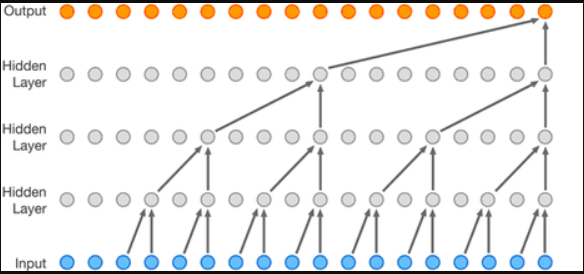

In [26]:
# it's useful because we now don't want to compute the 8 (block_size) inputs at once
# but as the structure shows, make them into groups and compute each group in parallel
# (1 2) (3 4) (5 6) (7 8)
# so before it's [batch_size,block_size*n_embd] @ [block_size*n_embd,n_hidden]
print((torch.randn((4,80)) @ torch.randn((80,200)) + torch.randn((200))).shape)
# now we want split it into 4 groups, which is [batch_size,4,block_size*n_embd/4] @ [block_size*n_embd/4,n_hidden]
print((torch.randn((4,4,20)) @ torch.randn((20,200)) + torch.randn((200))).shape)
# so we have to change our flatten layer

torch.Size([4, 200])
torch.Size([4, 4, 200])


In [27]:
# little trick of python slice
print(list(range(10))[::2]) # to get the even indices
print(list(range(10))[1::2]) # to get the odd indices

[0, 2, 4, 6, 8]
[1, 3, 5, 7, 9]


In [28]:
# so one way to get what we want
e = torch.randn((4,8,10)) # this is the shape of the embedding layer output, after flatten layer, we want it to be [4,4,20]
print(e[:,::2,:].shape)
explict = torch.cat([e[:,::2,:],e[:,1::2,:]],dim=2)
explict.shape

torch.Size([4, 4, 10])


torch.Size([4, 4, 20])

In [29]:
# or of course we can simply use
(explict == e.view(4,4,20)).all() # tensor.all() tests if all elements in input evaluate to True.

tensor(True)

In [30]:
# now let's modify the flatten layer
class FlattenConsecutive: # it's different from torch.nn.Flatten, so we give it a different name
  def __init__(self,n):
    self.n = n
  def __call__(self,x):
    B, T, C = x.shape # batch_size, block_size, n_embd
    x = x.view(B,-1,C*self.n) # or x.view(B,T//n,C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  def parameters(self):
    return []

In [31]:
n_hidden = 68 # so the number of parameters will be the same as before, so we can compare the performance of these two structures
# now the model is
model = Sequential([
    Embedding(vocab_size,n_embd),
    FlattenConsecutive(2), Linear(2 * n_embd,n_hidden,bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(2 *n_hidden,n_hidden,bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(2 *n_hidden,n_hidden,bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,vocab_size),
])
with torch.no_grad():
  model.layers[-1].weight *= 0.1
parameters = model.parameters()
print(sum([p.nelement() for p in parameters]))
for p in parameters:
  p.requires_grad = True

22397


In [32]:
# First, let's look at all the shapes of outputs of each layer
ix = torch.randint(0,len(Xtr),(4,)) # let's look at a batch of just 4 examples
Xb,Yb = Xtr[ix],Ytr[ix]
logits = model(Xb)
for layer in model.layers:
  print(layer.__class__.__name__,layer.out.shape)
# from the shape we can see that it works just like wavenet structure shows
# however, batchnorm layer works just fine even it gets a 3-dim input now, it is because broadcasting, and it's not want we want

Embedding torch.Size([4, 8, 10])
FlattenConsecutive torch.Size([4, 4, 20])
Linear torch.Size([4, 4, 68])
BatchNorm1d torch.Size([4, 4, 68])
Tanh torch.Size([4, 4, 68])
FlattenConsecutive torch.Size([4, 2, 136])
Linear torch.Size([4, 2, 68])
BatchNorm1d torch.Size([4, 2, 68])
Tanh torch.Size([4, 2, 68])
FlattenConsecutive torch.Size([4, 136])
Linear torch.Size([4, 68])
BatchNorm1d torch.Size([4, 68])
Tanh torch.Size([4, 68])
Linear torch.Size([4, 27])


In [33]:
# let's see what's going on in batch norm
e = torch.randn((32,4,68)) # let's use this as an example of the BatchNorm1d Layer's input
# below is exactly what we do in the batchnorm layer
emean = e.mean(dim=0,keepdim=True) # shape = [1,4,68]
evar = e.var(dim=0,keepdim=True)   # shape = [1,4,68]
ehat = (e-emean)/torch.sqrt(evar)  # shape = [32,4,68]
print(ehat.shape)
# so before, we take mean and variance over dimension=0 because back then that is the batch dimension
# but now we want the mean and variance over dim 0 and dim 1 because they are the batch dimension now

torch.Size([32, 4, 68])


In [34]:
# here is what we gonna do
# for torch mean or variance methods, dim can be int or tuple
emean = e.mean(dim=(0,1),keepdim=True)
evar = e.var(dim=(0,1),keepdim=True)
ehat = (e-emean)/torch.sqrt(evar)
# as broadcasting works, the output shape remains the same
emean.shape, evar.shape, ehat.shape

(torch.Size([1, 1, 68]), torch.Size([1, 1, 68]), torch.Size([32, 4, 68]))

In [35]:
# so let's modify the BatchNorm1d class
class BatchNorm1d:
  def __init__(self,dim,momentum=0.1,eps=1e-5):
    self.momentum = momentum
    self.eps = eps
    self.training = True
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
    self.gamma = torch.ones(dim)
    self.beta = torch.ones(dim)

  def __call__(self,x):
    if self.training:
      if x.ndim == 2:
        dim = 0
      if x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim=dim,keepdim=True)
      xvar = x.var(dim=dim,keepdim=True)
      with torch.no_grad():
        self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*xmean
        self.running_var = (1-self.momentum)*self.running_var + self.momentum*xvar
    else:
      xmean = self.running_mean
      xvar = self.running_var
    self.out = self.gamma * (x-xmean)/torch.sqrt(xvar+self.eps) + self.beta
    return self.out
  def parameters(self):
    return [self.gamma,self.beta]

In [36]:
# let's re initialize the model
model = Sequential([
    Embedding(vocab_size,n_embd),
    FlattenConsecutive(2), Linear(2 * n_embd,n_hidden,bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(2 *n_hidden,n_hidden,bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(2 *n_hidden,n_hidden,bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,vocab_size),
])
with torch.no_grad():
  model.layers[-1].weight *= 0.1
parameters = model.parameters()
print(sum([p.nelement() for p in parameters]))
for p in parameters:
  p.requires_grad = True

22397


In [37]:
# Let's train the model
lossi = []
ud = []
for i in range(max_steps):
  # minibatch
  ix = torch.randint(0,len(Xtr),(batch_size,))
  Xb,Yb = Xtr[ix],Ytr[ix]

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits,Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i<100000 else 0.001
  for p in parameters:
    p.data -= lr*p.grad

  # track stats
  lossi.append(loss.log10().item())
  if i%10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item()}')

  # break

      0/ 200000: 3.2697336673736572
  10000/ 200000: 2.089388132095337
  20000/ 200000: 2.2300631999969482
  30000/ 200000: 2.2381205558776855
  40000/ 200000: 1.973273754119873
  50000/ 200000: 2.060319423675537
  60000/ 200000: 1.7692363262176514
  70000/ 200000: 2.408045768737793
  80000/ 200000: 1.8965415954589844
  90000/ 200000: 1.5984950065612793
 100000/ 200000: 2.197232723236084
 110000/ 200000: 2.3005380630493164
 120000/ 200000: 2.4265236854553223
 130000/ 200000: 2.05766224861145
 140000/ 200000: 1.90035080909729
 150000/ 200000: 2.208603620529175
 160000/ 200000: 1.9833394289016724
 170000/ 200000: 1.8579416275024414
 180000/ 200000: 1.9818134307861328
 190000/ 200000: 1.6222437620162964


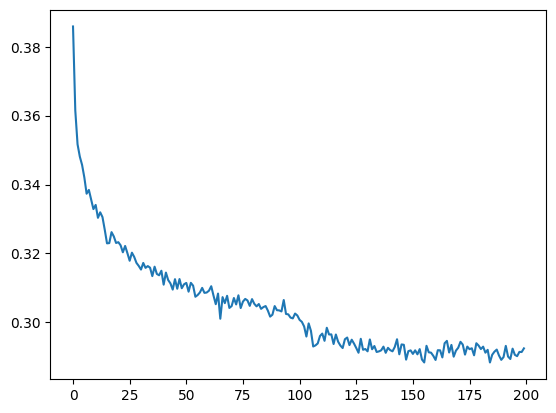

In [41]:
plt.plot(torch.tensor([lossi]).view(-1,1000).mean(1))

In [39]:
# evaluation mode
for layer in model.layers:
  layer.training = False

def split_loss(split):
  x,y = {
      'train':[Xtr,Ytr],
      'val':[Xdev,Ydev],
      'test':[Xte,Yte]
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits,y)
  print(split,loss.item())

with torch.no_grad():
  split_loss('train')
  split_loss('val')

train 1.9342260360717773
val 2.02044939994812


performance log:
  * original (context 3, 200 hidden neurons, 12K params): train 2.0679, val 2.1045

  * context 8, 200 hidden neurons, 22K params: train 1.9345, val 2.0282
  * wavenet, 68 hidden neurons, 22K params: train 1.9342, val 2.0204